In [1]:
import numpy as np
from scipy.stats import ks_2samp
from scipy import stats
import matplotlib.pyplot as plt
import h5py
import time

In [2]:
pop_file_loc = "/home/pranavsatheesh/host_galaxies/data/population_files/"
pop_file = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001.hdf5"

In [2]:
pop_file_loc = "/home/pranavsatheesh/host_galaxies/merger_file_runs/"
pop_file = pop_file_loc + "population_sort_gas-100_dm-100_star-100_bh-001.hdf5"

In [3]:
pop = h5py.File(pop_file, 'r')
# Mstar_merging = pop['merging_population']['Mstar'][:]
# Mstar_non_merging = pop['non_merging_population']['Mstar'][:]

In [5]:
pop['merging_population'].keys()

<KeysViewHDF5 ['MBH', 'MBH_1', 'MBH_2', 'Mdot', 'Mgas', 'Mstar', 'SFR', 'q_merger', 'snap', 'subhalo_ids', 'z']>

In [6]:
pop['major_merging_population'].keys()

<KeysViewHDF5 ['MBH', 'MBH_1', 'MBH_2', 'Mdot', 'Mgas', 'Mstar', 'SFR', 'q_merger', 'snap', 'subhalo_ids', 'z']>

In [18]:
pop['major_merging_population']['MBH_1'].shape

(467,)

(array([  1.,   0.,   2.,   6.,   3.,  13.,  28.,  61., 140., 213.]),
 array([-2.42837510e+00, -2.18554735e+00, -1.94271959e+00, -1.69989184e+00,
        -1.45706408e+00, -1.21423633e+00, -9.71408575e-01, -7.28580820e-01,
        -4.85753065e-01, -2.42925310e-01, -9.75550821e-05]),
 <BarContainer object of 10 artists>)

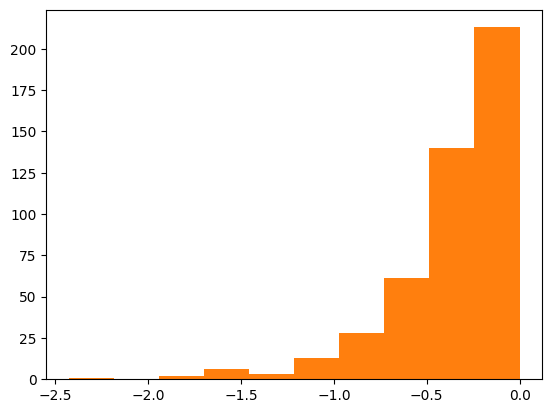

In [15]:
plt.hist(np.log10(pop['major_merging_population']['q_merger'][:]))
plt.hist(np.log10(pop['merging_population']['q_merger'][:]))

### Algorithm 1: Assigning a weight to each galaxies 

In [5]:
def generate_control_sample_restrictive(pop,z_tol_def = 0.01,Mstar_dex_tol_def = 0.1):
    start_time = time.time()

    control_sample = {
        "idx": np.array([], dtype=int),
        "subhalo_ids": [],
        "snap": [],
        "z": [],
        "Mstar": [],
        "z_tol": [],
        "Mstar_dex_tol": []
    }

    for i in range(len(pop['merging_population']["z"])):
        z_mrg = pop['merging_population']["z"][i]
        Mstar_mrg = pop['merging_population']["Mstar"][i]

        z_tol = z_tol_def
        Mstar_dex_tol = Mstar_dex_tol_def
        
        idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))
        
        while (np.size(idxs) < 10 and Mstar_dex_tol < 0.3):
            z_tol *= 1.5  # increase the tolerances by 50 percent
            Mstar_dex_tol *= 1.5
            idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & 
                            (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))

        control_sample["idx"] = np.append(control_sample["idx"], i)
        control_sample["z_tol"].append(z_tol)
        control_sample["Mstar_dex_tol"].append(Mstar_dex_tol)
        control_sample["subhalo_ids"].append(pop['non_merging_population']["subhalo_ids"][idxs])
        control_sample["snap"].append(pop['non_merging_population']["snap"][idxs])
        control_sample["z"].append(pop['non_merging_population']["z"][idxs])
        control_sample["Mstar"].append(pop['non_merging_population']["Mstar"][idxs])
    
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")

    return control_sample

In [10]:
def generate_control_sample(pop,z_tol_def = 0.01,Mstar_dex_tol_def = 0.1):
    start_time = time.time()

    control_sample = {
        "idx": np.array([], dtype=int),
        "subhalo_ids": [],
        "snap": [],
        "z": [],
        "Mstar": [],
        "z_tol": [],
        "Mstar_dex_tol": []
    }

    for i in range(len(pop['merging_population']["z"])):
        z_mrg = pop['merging_population']["z"][i]
        Mstar_mrg = pop['merging_population']["Mstar"][i]

        z_tol = z_tol_def
        Mstar_dex_tol = Mstar_dex_tol_def
        
        idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))
        
        while (np.size(idxs) < 10):
            z_tol *= 1.5  # increase the tolerances by 50 percent
            Mstar_dex_tol *= 1.5
            idxs = np.where((np.abs(pop['non_merging_population']["z"] - z_mrg) <= z_tol) & 
                            (np.abs(np.log10(pop['non_merging_population']["Mstar"]) - np.log10(Mstar_mrg)) <= Mstar_dex_tol))

        control_sample["idx"] = np.append(control_sample["idx"], i)
        control_sample["z_tol"]=np.append(control_sample["z_tol"],z_tol)
        control_sample["Mstar_dex_tol"]=np.append(control_sample["Mstar_dex_tol"],Mstar_dex_tol)
       #control_sample["z_tol"].append(z_tol)
        #control_sample["Mstar_dex_tol"].append(Mstar_dex_tol)
        control_sample["subhalo_ids"].append(pop['non_merging_population']["subhalo_ids"][idxs])
        control_sample["snap"].append(pop['non_merging_population']["snap"][idxs])
        control_sample["z"].append(pop['non_merging_population']["z"][idxs])
        control_sample["Mstar"].append(pop['non_merging_population']["Mstar"][idxs])
    
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")

    return control_sample

In [11]:
control_def = generate_control_sample(pop)
control_restrictive = generate_control_sample_restrictive(pop)

Elapsed time: 28.67768144607544 seconds
Elapsed time: 28.13616156578064 seconds


## Algorithm 2: Using KS matching 

In [6]:
pop['merging_population'].keys()

<KeysViewHDF5 ['MBH', 'Mdot', 'Mgas', 'Mstar', 'SFR', 'snap', 'subhalo_ids', 'z']>

In [7]:
N_mergers = len(pop['merging_population']['MBH'])
print(N_mergers)
N_non_mergers = len(pop['non_merging_population']['MBH'])

467


In [8]:
control_indices = np.arange(0,N_non_mergers)

In [9]:
control_mask = np.ones(N_non_mergers, dtype=bool)

In [10]:
control_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [11]:
from scipy.spatial import cKDTree
from scipy.spatial import distance


In [12]:
# Extract coordinates
merging_points = np.column_stack((pop['merging_population']['z'], pop['merging_population']['Mstar']))
non_merging_points = np.column_stack((pop['non_merging_population']['z'], pop['non_merging_population']['Mstar']))

# Compute pairwise Euclidean distances
dist_matrix = distance.cdist(merging_points, non_merging_points)

KeyboardInterrupt: 

In [13]:
from tqdm import tqdm

In [ ]:
merging_points = np.column_stack((pop['merging_population']['z'], np.log10(pop['merging_population']['Mstar'])))
non_merging_points = np.column_stack((pop['non_merging_population']['z'], np.log10(pop['non_merging_population']['Mstar'])))

# Build a KDTree for fast nearest neighbor search
tree = cKDTree(non_merging_points)

# Track used indices
used = np.zeros(len(non_merging_points), dtype=bool)  # False means available
#closest_indices = np.full(len(merging_points), -1)  # Store assigned indices

control_indices = []

p_z = 1.0  # or set an initial value
p_Mstar = 1.0  # or set an initial value

# Perform the loop with initial values
while True:
    closest_indices = np.full(len(merging_points), -1)  # Store assigned indices

    for i in tqdm(range(len(merging_points)), desc="Processing merging points", ncols=100):
    #for i in range(len(merging_points)):
    # Find the closest available neighbor
        d, min_index = tree.query(merging_points[i])

        if (used[min_index]): # If already taken, find the next closest manually
            dists, idxs = tree.query(merging_points[i], k=len(non_merging_points))  # Get sorted neighbor
            min_index = idxs[np.where(~used[idxs])[0][0]]  # Find first unused index


        # Ensure we select an unused index
        #while used[min_index]:  # If already taken, find the next closest manually
            #dists, idxs = tree.query(merging_points[i], k=len(non_merging_points))  # Get sorted neighbors
            #min_index = idxs[np.where(~used[idxs])[0][0]]  # Find first unused index
        
        # Store the match and mark as used
        closest_indices[i] = min_index
        used[min_index] = True  # Mark as used

    control_indices.append(closest_indices)
    print(len(pop['non_merging_population']['Mstar'][np.sort(closest_indices)]),len(pop['non_merging_population']['z'][np.sort(closest_indices)]))

    D_mstar, p_Mstar = ks_2samp(pop['non_merging_population']['Mstar'][np.sort(closest_indices)],pop['merging_population']['Mstar'])
    D_z, p_z = ks_2samp(pop['non_merging_population']['z'][np.sort(closest_indices)],pop['merging_population']['z'])
    print(p_z,p_Mstar,np.shape(control_indices)[0])
    
    if p_z < 0.99 or p_Mstar < 0.99 or np.shape(control_indices)[0]>=10:
        
        break  # Exit the loop if both conditions are no longer true

# `closest_indices` now contains the nearest non-merging index for each merging point without replacement.

In [77]:
D_mstar, p_Mstar = ks_2samp(pop['non_merging_population']['Mstar'][sorted_indices],pop['merging_population']['Mstar'])

In [121]:
control_z = np.array(control_indices).flatten()

(array([0.39432499, 0.364322  , 0.31717445, 0.27859918, 0.28288532,
        0.12001195, 0.16287337, 0.02571685, 0.03000299, 0.02571685]),
 array([2.22044605e-16, 4.99593347e-01, 9.99186694e-01, 1.49878004e+00,
        1.99837339e+00, 2.49796673e+00, 2.99756008e+00, 3.49715343e+00,
        3.99674677e+00, 4.49634012e+00, 4.99593347e+00]),
 [<matplotlib.patches.Polygon at 0x1528b786b8b0>])

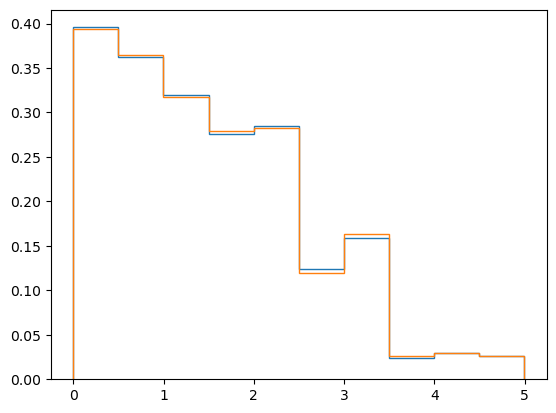

In [127]:
sorted_indices = np.sort(closest_indices)
plt.hist(pop['non_merging_population']['z'][np.sort(control_z)],histtype="step",density=True)
#plt.hist(pop['non_merging_population']['z'][sorted_indices],histtype="step")
plt.hist(pop['merging_population']['z'],histtype="step",density=True)

In [1]:
# Filter out non-positive SFR values
log_sfr_non_merging = np.log10(pop['non_merging_population']['SFR'][np.sort(control_z)])
log_sfr_merging = np.log10(pop['merging_population']['SFR'])

# Remove any non-positive values (SFR <= 0)
log_sfr_non_merging = log_sfr_non_merging[log_sfr_non_merging > 0]
log_sfr_merging = log_sfr_merging[log_sfr_merging > 0]

# Create the histograms for both distributions, normalized to the same area (density=True)
plt.hist(log_sfr_non_merging, histtype="step", density=True, bins=10, label="Non-merging")
plt.hist(log_sfr_merging, histtype="step", density=True, bins=10, label="Merging")

# Add a legend and axis labels
plt.legend()
plt.xlabel("Log10(SFR)")
plt.ylabel("Density")
plt.show()

NameError: name 'np' is not defined

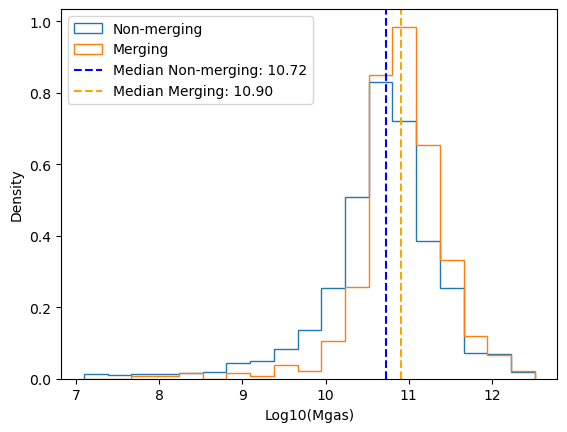

In [141]:
# Filter out non-positive Mgas values
log_mgas_non_merging = np.log10(pop['non_merging_population']['Mgas'][np.sort(control_z)])
log_mgas_merging = np.log10(pop['merging_population']['Mgas'])

# Remove any non-positive values (Mgas <= 0)
log_mgas_non_merging = log_mgas_non_merging[log_mgas_non_merging > 0]
log_mgas_merging = log_mgas_merging[log_mgas_merging > 0]

# Define the bins for Mgas (logarithmic bins or linear bins depending on your needs)
bins = np.linspace(np.min(log_mgas_non_merging),np.max(log_mgas_non_merging), 20)

# Create the histograms for both distributions, normalized to the same area (density=True)
plt.hist(log_mgas_non_merging, histtype="step", density=True, bins=bins, label="Non-merging")
plt.hist(log_mgas_merging, histtype="step", density=True, bins=bins, label="Merging")

median_non_merging = np.median(log_mgas_non_merging)
median_merging = np.median(log_mgas_merging)

plt.axvline(median_non_merging, color='blue', linestyle='--', label=f"Median Non-merging: {median_non_merging:.2f}")
plt.axvline(median_merging, color='orange', linestyle='--', label=f"Median Merging: {median_merging:.2f}")

# Add a legend and axis labels
plt.legend()
#plt.xscale('log')  # Use logarithmic x-axis for better visibility
plt.xlabel("Log10(Mgas)")
plt.ylabel("Density")
plt.show()


In [40]:
control_sample_test  = "control_sample_testfile.hdf5"

In [41]:
for key, value in control_def.items():
    print(key,isinstance(value, list))

idx False
subhalo_ids True
snap True
z True
Mstar True
z_tol False
Mstar_dex_tol False


In [44]:
with h5py.File(control_sample_test, 'w') as f:
            for key, value in control_def.items():
                # Define a variable-length data type
                vlen_dtype = h5py.special_dtype(vlen=np.dtype('float64'))
                
                # Create a dataset with the variable-length data type
                if isinstance(value, list):
                    dset = f.create_dataset(key, (len(value),), dtype=vlen_dtype)
                    dset[:] = value
                else:
                    f.create_dataset(key, data=value)

In [43]:
f.close()
control_sample_tst.close()

In [46]:
control_sample_tst = h5py.File(control_sample_test, 'r')


In [49]:
control_sample_tst['z_tol'][1]

0.01

In [ ]:
Mstar_tol_max_non_restrictive = np.max(control_def['z_tol'])
Mstar_tol_max_restrictive = np.max(control_restrictive['z_tol'])

In [9]:
print(f"The maximum tolerance in z is {np.max(control_sample['z_tol']):.3f}")
print(f"The maximum tolerance in $M_{{\star}}$ is {np.max(control_sample['Mstar_dex_tol']):.3f}")
lengths_subhalo_ids = [len(sublist) for sublist in control_sample['subhalo_ids']]
print(f"The average number of control samples is {np.mean(lengths_subhalo_ids):.0f}")
print(f"The minimum number of control samples is {np.min(lengths_subhalo_ids):.0f}")

The maximum tolerance in z is 0.076
The maximum tolerance in $M_{\star}$ is 0.759
The average number of control samples is 151
The minimum number of control samples is 10


In [65]:
def weight_Mstar(i,pop,control):
    return 1  - np.abs(np.log10(pop["merging_population"]["Mstar"][i])- np.log10(control["Mstar"][i]))/control["Mstar_dex_tol"][i]

def weight_z(i,pop,control):
    return 1  - np.abs(np.log10(pop["merging_population"]["z"][i])- np.log10(control["z"][i]))/control["z_tol"][i]

def weight_tot(i,pop,control):
    return weight_z(i,pop,control)*weight_Mstar(i,pop,control)

def control_prop_avg(prop_key,index,pop,control):
    control_pop = control[prop_key][index]
    control_weights = weight_tot(index,pop,control)
    control_avg = np.sum(control_weights*control_pop)/np.sum(control_weights)
    return control_avg

In [66]:
N_mergers = len(pop['merging_population']["z"])

control_z_avg = np.array([control_prop_avg("z", i,pop,control_def) for i in range(N_mergers)])
control_Mstar_avg = np.array([control_prop_avg("Mstar", i,pop,control_def) for i in range(N_mergers)])

control_restrictive_z_avg = np.array([control_prop_avg("z", i,pop,control_restrictive) for i in range(N_mergers)])
control_restrictive_Mstar_avg = np.array([control_prop_avg("Mstar", i,pop,control_restrictive) for i in range(N_mergers)])

In [67]:
Mstar_binsize = 0.5  # specify the binsize
Mstar_min = 7
Mstar_max = 12
Nbins_Ms = int((Mstar_max-Mstar_min)/Mstar_binsize)
Mstar_bins = np.linspace(Mstar_min,Mstar_max,Nbins_Ms)

z_binsize = 0.1  
z_min = 0
z_max = 5
Nbins_z = int((z_max - z_min) / z_binsize)
z_bins = np.linspace(z_min, z_max, Nbins_z)

Text(0.5, 0, '$\\log(M_{\\star}/M_{\\odot})$')

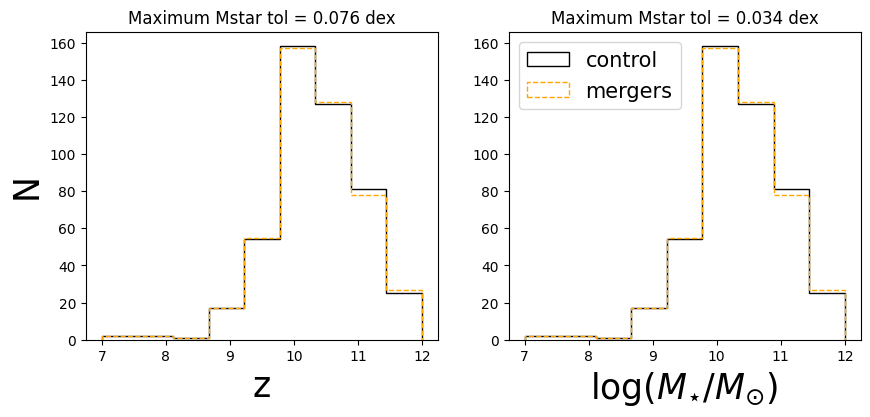

In [77]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(np.log10(control_Mstar_avg), bins=Mstar_bins,histtype="step",color="black",label="control")
ax[0].hist(np.log10(pop['merging_population']['Mstar']),bins=Mstar_bins,histtype="step",label="mergers",color="orange",linestyle="--")
ax[0].set_title(f"Maximum Mstar tol = %2.3f dex"%(Mstar_tol_max_non_restrictive))
ax[0].set_xlabel("z",fontsize=25)
ax[0].set_ylabel("N",fontsize=25)


ax[1].hist(np.log10(control_restrictive_Mstar_avg), bins=Mstar_bins,histtype="step",color="black",label="control")
ax[1].hist(np.log10(pop['merging_population']['Mstar']),bins=Mstar_bins,histtype="step",label="mergers",color="orange",linestyle="--")
ax[1].set_title(f"Maximum Mstar tol = %2.3f dex"%(Mstar_tol_max_restrictive))
ax[1].legend(fontsize=15)
ax[1].set_xlabel("$\log(M_{\star}/M_{\odot})$",fontsize=25)

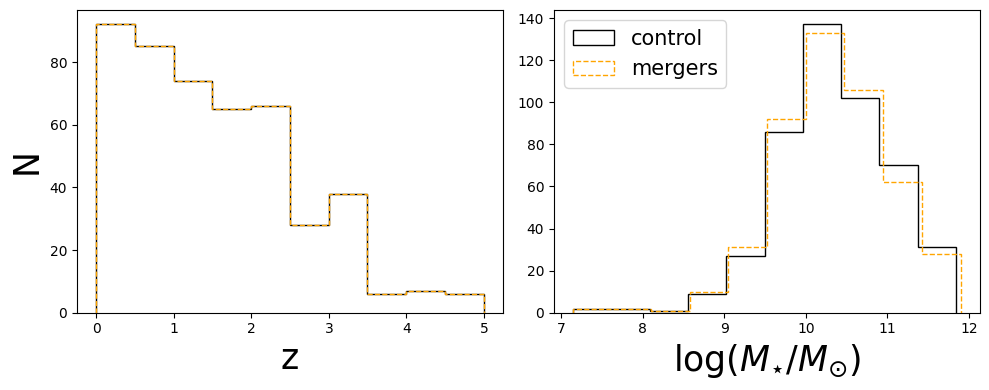

In [21]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
control_z_avg = np.array([control_prop_avg("z", i) for i in range(N_mergers)])
ax[0].hist(control_z_avg,histtype="step",color="black",label="control")
ax[0].hist(pop['merging_population']['z'],histtype="step",label="mergers",color="orange",linestyle="--")

ax[0].set_xlabel("z",fontsize=25)
ax[0].set_ylabel("N",fontsize=25)

control_Mstar_avg = np.array([control_prop_avg("Mstar", i) for i in range(N_mergers)])
ax[1].hist(np.log10(control_Mstar_avg),histtype="step",color="black",label="control")
ax[1].hist(np.log10(pop['merging_population']['Mstar']),histtype="step",label="mergers",color="orange",linestyle="--")
ax[1].legend(fontsize=15)
ax[1].set_xlabel("$\log(M_{\star}/M_{\odot})$",fontsize=25)
#ax[1].set_ylabel("N",fontsize=25)
fig.tight_layout()

In [76]:
D_z,p_value_z = ks_2samp(control_z_avg,pop['merging_population']['z'])
D_Mstar,p_value_Mstar = ks_2samp(np.log10(control_Mstar_avg),np.log10(pop['merging_population']['Mstar']))
print(f"Redshift matching gives KS statistic of {D_z:2.3f} and p-value of {p_value_z}")
print(f"Mstar matching gives KS statistic of {D_Mstar:.3f} and p-value of {p_value_Mstar}")

Redshift matching gives KS statistic of 0.017 and p-value of 0.9999998707742743
Mstar matching gives KS statistic of 0.015 and p-value of 0.9999999994509645


In [75]:
D_z,p_value_z = ks_2samp(control_restrictive_z_avg,pop['merging_population']['z'])
D_Mstar,p_value_Mstar = ks_2samp(np.log10(control_restrictive_Mstar_avg),np.log10(pop['merging_population']['Mstar']))
print(f"Redshift matching gives KS statistic of {D_z:2.3f} and p-value of {p_value_z}")
print(f"Mstar matching gives KS statistic of {D_Mstar:.3f} and p-value of {p_value_Mstar}")

Redshift matching gives KS statistic of 0.017 and p-value of 0.9999998707742743
Mstar matching gives KS statistic of 0.011 and p-value of 0.9999999999999998


In [ ]:
control_sample_file =  "control_sample.hdf5"

      

with h5py.File(control_sample_file, 'w') as f:
    for key, value in control_sample.items():
        if isinstance(value, list):
            group = f.create_group(key)
            for i, array in enumerate(value):
                group.create_dataset(str(i), data=array)
        else:
            f.create_dataset(key, data=value)

f.close()

In [ ]:
with h5py.File(control_sample_file, 'w') as f:
    for key, value in control_sample.items():
        # Define a variable-length data type
        vlen_dtype = h5py.special_dtype(vlen=np.dtype('float64'))
        
        # Create a dataset with the variable-length data type
        if isinstance(value, list):
            dset = f.create_dataset(key, (len(value),), dtype=vlen_dtype)
            dset[:] = value
        else:
            f.create_dataset(key, data=value)